In [ ]:
"""
Distance Metrics Comparison
This notebook compares different distance metrics to determine which best
captures metabolic similarity for clustering:
1. Calculate multiple distance matrices (Euclidean, Manhattan, Cosine)
2. Compare distance distributions
3. Assess correlation between metrics
4. Test clinical interpretability
5. Evaluate impact on preliminary clustering
6. Recommend optimal distance metric

"""

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Pastel colors
pastel_colors = ['#FFB6C1', '#B0E0E6', '#DDA0DD', '#F0E68C', '#98FB98', 
                 '#FFE4B5', '#E6E6FA', '#FFC0CB']
sns.set_palette(pastel_colors)


DISTANCE METRICS COMPARISON - PHASE 2, STEP 5
Determining optimal distance metric for metabolic clustering



In [11]:
# Load scaled data for distance calculations
df_scaled = pd.read_csv("../../data/processed/nhanes_metabolic_scaled.csv")

print(f"Loaded scaled data: {df_scaled.shape[0]:,} participants × {df_scaled.shape[1]} variables")

# Select core scaled variables
core_vars_scaled = ['LBXGLU_scaled', 'LBXTLG_scaled', 'BMXWAIST_scaled']

# Extract as numpy array for distance calculations
X = df_scaled[core_vars_scaled].values

print(f"\nData for distance calculation:")
print(f"  Shape: {X.shape}")
print(f"  Variables: {core_vars_scaled}")
print(f"\nScaled data statistics:")
print(pd.DataFrame(X, columns=core_vars_scaled).describe().round(3))

# Verify scaling
print(f"\nMeans (should be ~0): {X.mean(axis=0)}")
print(f"Std devs (should be ~1): {X.std(axis=0)}")

Loaded scaled data: 3,047 participants × 45 variables

Data for distance calculation:
  Shape: (3047, 3)
  Variables: ['LBXGLU_scaled', 'LBXTLG_scaled', 'BMXWAIST_scaled']

Scaled data statistics:
       LBXGLU_scaled  LBXTLG_scaled  BMXWAIST_scaled
count       3047.000       3047.000         3047.000
mean           0.498          0.310            0.064
std            2.080          1.287            0.757
min           -2.625         -1.088           -1.757
25%           -0.438         -0.382           -0.482
50%            0.000          0.000            0.000
75%            0.562          0.618            0.518
max           28.750         24.206            3.523

Means (should be ~0): [0.49805136 0.30954266 0.06355239]
Std devs (should be ~1): [2.07997337 1.28717711 0.75645464]


In [12]:
# Calculate pairwise distances using different metrics
print("CALCULATING DISTANCE MATRICES\n")

# Calculate condensed distance matrices (upper triangle)
print("Computing Euclidean distances...")
euclidean_dist = pdist(X, metric='euclidean')

print("Computing Manhattan distances...")
manhattan_dist = pdist(X, metric='cityblock')

print("Computing Cosine distances...")
cosine_dist = pdist(X, metric='cosine')

# Convert to square matrices for easier analysis
print("Converting to square matrices...")
euclidean_matrix = squareform(euclidean_dist)
manhattan_matrix = squareform(manhattan_dist)
cosine_matrix = squareform(cosine_dist)

print("\nDistance matrices computed:")
print(f"  Euclidean: {euclidean_matrix.shape}")
print(f"  Manhattan: {manhattan_matrix.shape}")
print(f"  Cosine: {cosine_matrix.shape}")

# Basic statistics for each metric
print("\nDistance Statistics:")
metrics_stats = pd.DataFrame({
    'Metric': ['Euclidean', 'Manhattan', 'Cosine'],
    'Mean': [euclidean_dist.mean(), manhattan_dist.mean(), cosine_dist.mean()],
    'Std': [euclidean_dist.std(), manhattan_dist.std(), cosine_dist.std()],
    'Min': [euclidean_dist.min(), manhattan_dist.min(), cosine_dist.min()],
    'Max': [euclidean_dist.max(), manhattan_dist.max(), cosine_dist.max()],
    'Median': [np.median(euclidean_dist), np.median(manhattan_dist), np.median(cosine_dist)]
})
print(metrics_stats.round(4))

CALCULATING DISTANCE MATRICES

Computing Euclidean distances...
Computing Manhattan distances...
Computing Cosine distances...
Converting to square matrices...

Distance matrices computed:
  Euclidean: (3047, 3047)
  Manhattan: (3047, 3047)
  Cosine: (3047, 3047)

Distance Statistics:
      Metric    Mean     Std  Min      Max  Median
0  Euclidean  2.5005  2.6196  0.0  31.4012  1.7790
1  Manhattan  3.5082  3.2804  0.0  45.3852  2.6331
2     Cosine  0.9952  0.6036  0.0   2.0000  1.0108


Saved: ../../results/figures/distance_distributions.png


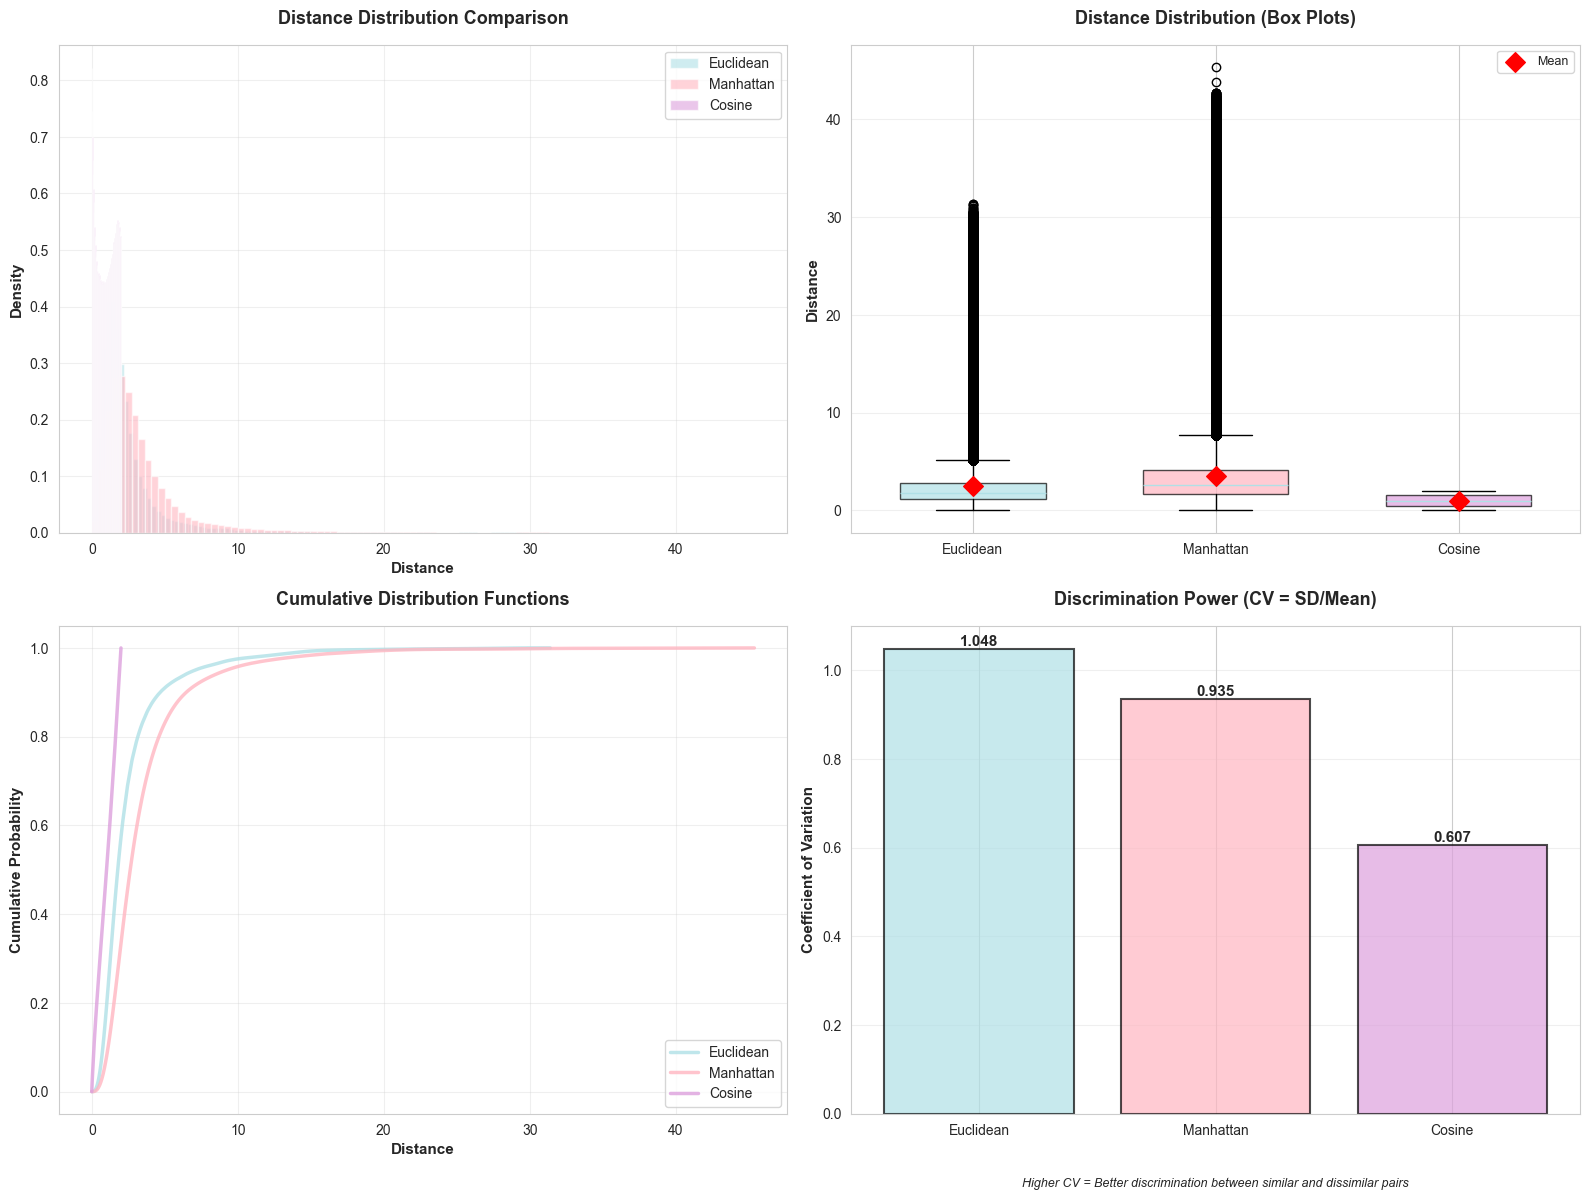


Discrimination Power (Coefficient of Variation):
  Euclidean: 1.0476
  Manhattan: 0.9351
  Cosine: 0.6065

→ Euclidean has highest CV (best discrimination)


In [13]:
# Compare distance distributions
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/distance_distributions.png'
    else:
        save_path = '../results/figures/distance_distributions.png'
else:
    save_path = 'results/figures/distance_distributions.png'

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Colors for each metric
colors_metrics = ['#B0E0E6', '#FFB6C1', '#DDA0DD']

# Plot 1: Overlaid histograms
ax1 = axes[0, 0]
ax1.hist(euclidean_dist, bins=100, alpha=0.6, color=colors_metrics[0], 
         label='Euclidean', density=True)
ax1.hist(manhattan_dist, bins=100, alpha=0.6, color=colors_metrics[1], 
         label='Manhattan', density=True)
ax1.hist(cosine_dist, bins=100, alpha=0.6, color=colors_metrics[2], 
         label='Cosine', density=True)
ax1.set_xlabel('Distance', fontsize=11, fontweight='bold')
ax1.set_ylabel('Density', fontsize=11, fontweight='bold')
ax1.set_title('Distance Distribution Comparison', fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Box plots
ax2 = axes[0, 1]
box_data = [euclidean_dist, manhattan_dist, cosine_dist]
bp = ax2.boxplot(box_data, labels=['Euclidean', 'Manhattan', 'Cosine'],
                 patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], colors_metrics):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Distance', fontsize=11, fontweight='bold')
ax2.set_title('Distance Distribution (Box Plots)', fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

# Add mean markers
means = [euclidean_dist.mean(), manhattan_dist.mean(), cosine_dist.mean()]
ax2.scatter([1, 2, 3], means, color='red', s=100, marker='D', 
           zorder=3, label='Mean')
ax2.legend(fontsize=9)

# Plot 3: Cumulative distributions
ax3 = axes[1, 0]
for dist, color, label in zip([euclidean_dist, manhattan_dist, cosine_dist],
                               colors_metrics,
                               ['Euclidean', 'Manhattan', 'Cosine']):
    sorted_dist = np.sort(dist)
    cumulative = np.arange(1, len(sorted_dist) + 1) / len(sorted_dist)
    ax3.plot(sorted_dist, cumulative, linewidth=2.5, color=color, 
            label=label, alpha=0.8)

ax3.set_xlabel('Distance', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
ax3.set_title('Cumulative Distribution Functions', fontsize=13, fontweight='bold', pad=15)
ax3.legend(fontsize=10, loc='lower right')
ax3.grid(True, alpha=0.3)

# Plot 4: Discrimination power (coefficient of variation)
ax4 = axes[1, 1]
cv_values = [
    euclidean_dist.std() / euclidean_dist.mean(),
    manhattan_dist.std() / manhattan_dist.mean(),
    cosine_dist.std() / cosine_dist.mean()
]
bars = ax4.bar(['Euclidean', 'Manhattan', 'Cosine'], cv_values, 
               color=colors_metrics, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Coefficient of Variation', fontsize=11, fontweight='bold')
ax4.set_title('Discrimination Power (CV = SD/Mean)', fontsize=13, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, cv_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add interpretation note
ax4.text(0.5, -0.15, 'Higher CV = Better discrimination between similar and dissimilar pairs',
         transform=ax4.transAxes, ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

# Print interpretation
print("\nDiscrimination Power (Coefficient of Variation):")
for metric, cv in zip(['Euclidean', 'Manhattan', 'Cosine'], cv_values):
    print(f"  {metric}: {cv:.4f}")

best_metric = ['Euclidean', 'Manhattan', 'Cosine'][np.argmax(cv_values)]
print(f"\n→ {best_metric} has highest CV (best discrimination)")

NameError: name 'euclidean_dist' is not defined

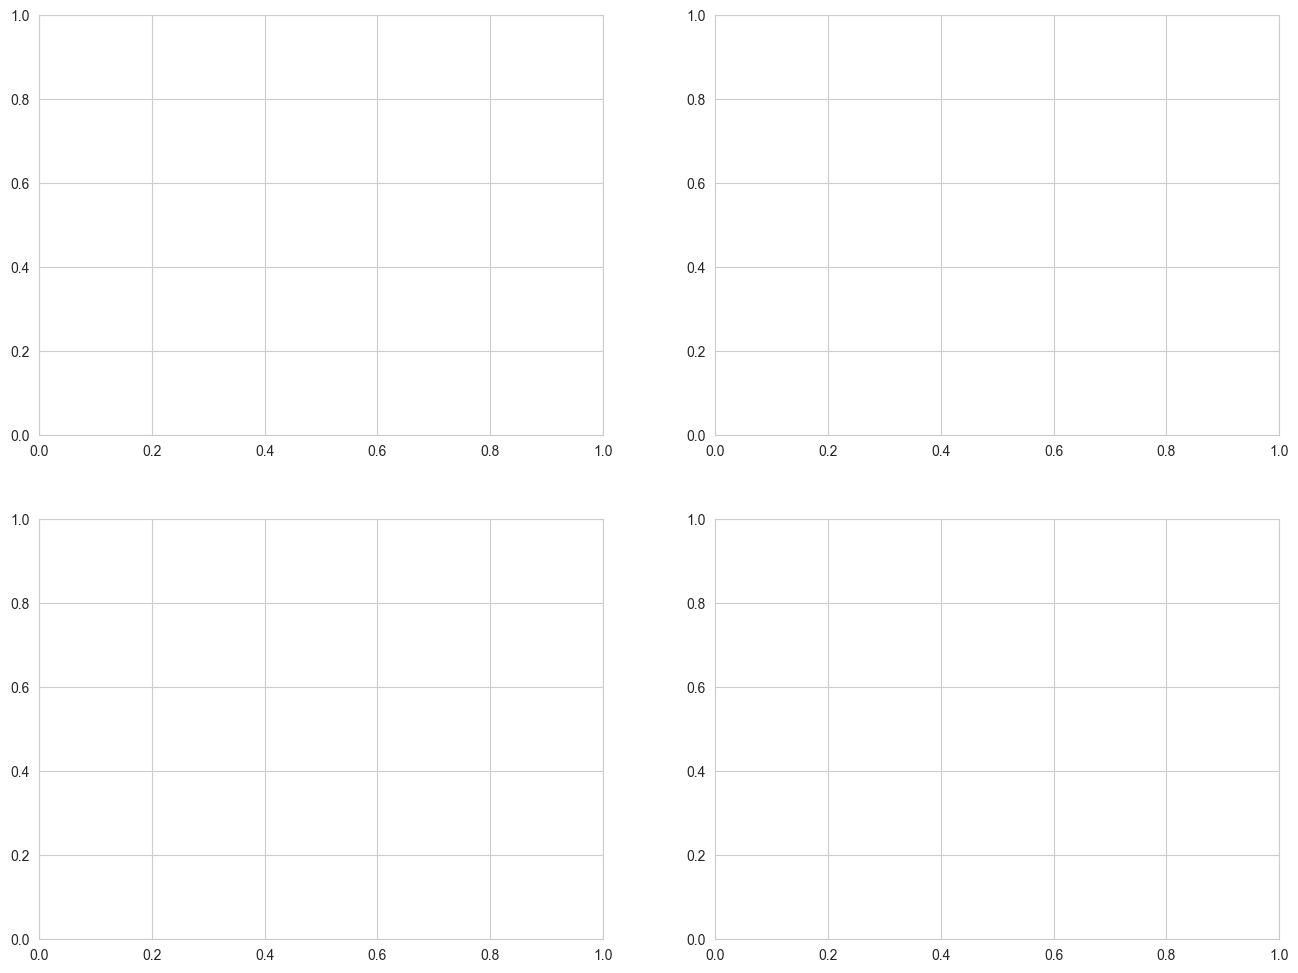

In [ ]:
# Compare distance distributions
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/distance_distributions.png'
    else:
        save_path = '../results/figures/distance_distributions.png'
else:
    save_path = 'results/figures/distance_distributions.png'

# Recalculate if needed (in case cell 3 wasn't run)
if 'euclidean_dist' not in locals():
    print("Recalculating distance matrices...")
    euclidean_dist = pdist(X, metric='euclidean')
    manhattan_dist = pdist(X, metric='cityblock')
    cosine_dist = pdist(X, metric='cosine')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Colors for each metric
colors_metrics = ['#B0E0E6', '#FFB6C1', '#DDA0DD']

# Plot 1: Overlaid histograms
ax1 = axes[0, 0]
ax1.hist(euclidean_dist, bins=100, alpha=0.6, color=colors_metrics[0], 
         label='Euclidean', density=True)
ax1.hist(manhattan_dist, bins=100, alpha=0.6, color=colors_metrics[1], 
         label='Manhattan', density=True)
ax1.hist(cosine_dist, bins=100, alpha=0.6, color=colors_metrics[2], 
         label='Cosine', density=True)
ax1.set_xlabel('Distance', fontsize=11, fontweight='bold')
ax1.set_ylabel('Density', fontsize=11, fontweight='bold')
ax1.set_title('Distance Distribution Comparison', fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Box plots
ax2 = axes[0, 1]
box_data = [euclidean_dist, manhattan_dist, cosine_dist]
bp = ax2.boxplot(box_data, labels=['Euclidean', 'Manhattan', 'Cosine'],
                 patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], colors_metrics):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Distance', fontsize=11, fontweight='bold')
ax2.set_title('Distance Distribution (Box Plots)', fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

# Add mean markers
means = [euclidean_dist.mean(), manhattan_dist.mean(), cosine_dist.mean()]
ax2.scatter([1, 2, 3], means, color='red', s=100, marker='D', 
           zorder=3, label='Mean')
ax2.legend(fontsize=9)

# Plot 3: Cumulative distributions
ax3 = axes[1, 0]
for dist, color, label in zip([euclidean_dist, manhattan_dist, cosine_dist],
                               colors_metrics,
                               ['Euclidean', 'Manhattan', 'Cosine']):
    sorted_dist = np.sort(dist)
    cumulative = np.arange(1, len(sorted_dist) + 1) / len(sorted_dist)
    ax3.plot(sorted_dist, cumulative, linewidth=2.5, color=color, 
            label=label, alpha=0.8)

ax3.set_xlabel('Distance', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
ax3.set_title('Cumulative Distribution Functions', fontsize=13, fontweight='bold', pad=15)
ax3.legend(fontsize=10, loc='lower right')
ax3.grid(True, alpha=0.3)

# Plot 4: Discrimination power (coefficient of variation)
ax4 = axes[1, 1]
cv_values = [
    euclidean_dist.std() / euclidean_dist.mean(),
    manhattan_dist.std() / manhattan_dist.mean(),
    cosine_dist.std() / cosine_dist.mean()
]
bars = ax4.bar(['Euclidean', 'Manhattan', 'Cosine'], cv_values, 
               color=colors_metrics, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Coefficient of Variation', fontsize=11, fontweight='bold')
ax4.set_title('Discrimination Power (CV = SD/Mean)', fontsize=13, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, cv_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add interpretation note
ax4.text(0.5, -0.15, 'Higher CV = Better discrimination between similar and dissimilar pairs',
         transform=ax4.transAxes, ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

# Print interpretation
print("\nDiscrimination Power (Coefficient of Variation):")
for metric, cv in zip(['Euclidean', 'Manhattan', 'Cosine'], cv_values):
    print(f"  {metric}: {cv:.4f}")

best_metric = ['Euclidean', 'Manhattan', 'Cosine'][np.argmax(cv_values)]
print(f"\n→ {best_metric} has highest CV (best discrimination)")

Saved: ../../results/figures/stratified_by_waist_tertiles.png


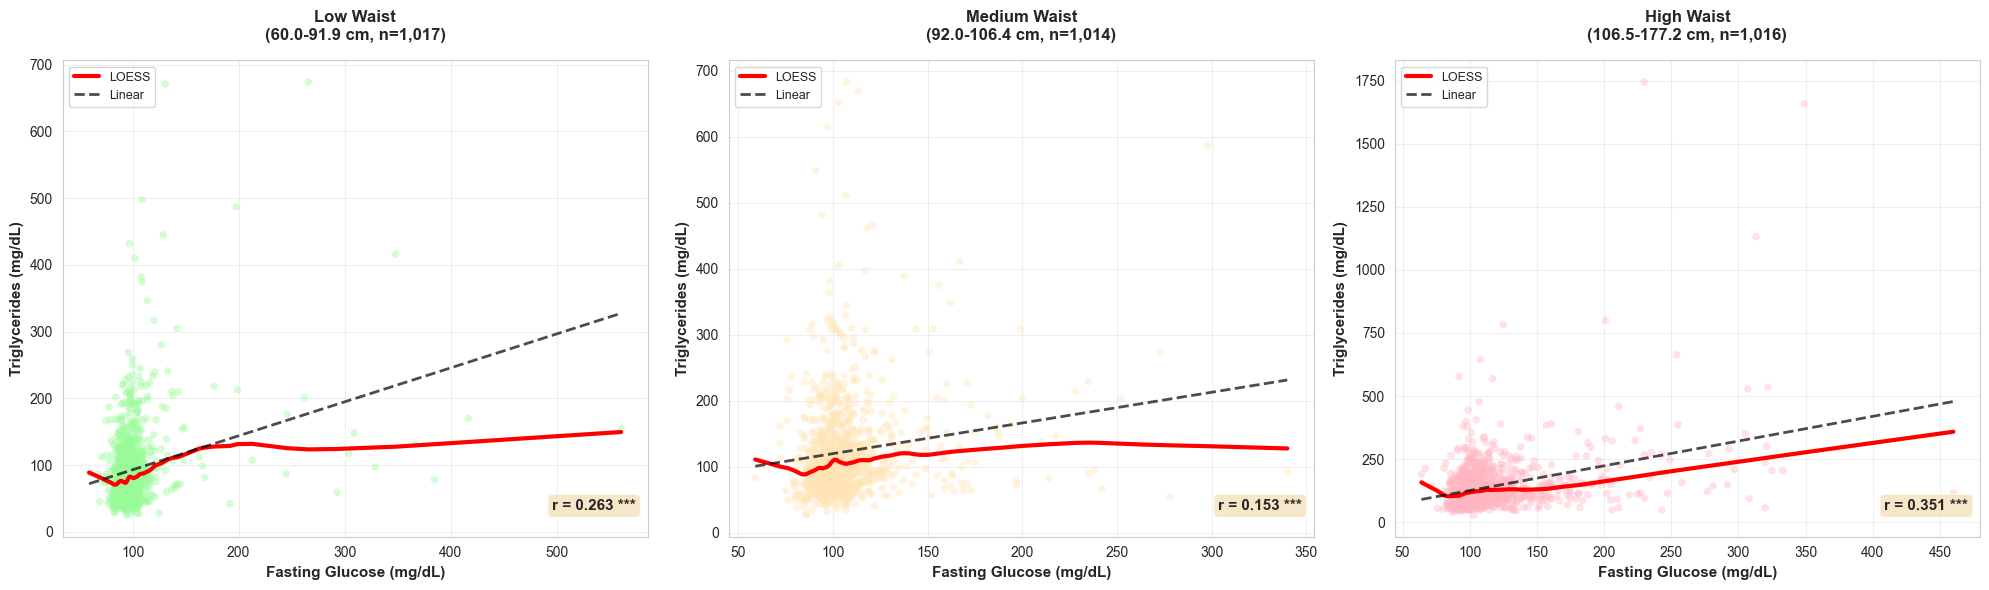


Correlation by Waist Tertile:
Tertile                     r      p-value        n
--------------------------------------------------
Low Waist               0.263   1.5378e-17    1,017
Medium Waist            0.153   9.8766e-07    1,014
High Waist              0.351   7.9323e-31    1,016

Interpretation:
  → Moderate interaction: correlation increases with waist circumference


In [23]:
# Stratify glucose vs triglycerides by waist circumference tertiles
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/stratified_by_waist_tertiles.png'
    else:
        save_path = '../results/figures/stratified_by_waist_tertiles.png'
else:
    save_path = 'results/figures/stratified_by_waist_tertiles.png'

# Create waist tertiles
df_complete['waist_tertile'] = pd.qcut(df_complete['BMXWAIST'], q=3, 
                                        labels=['Low Waist', 'Medium Waist', 'High Waist'])

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

tertile_colors = ['#98FB98', '#FFE4B5', '#FFB6C1']
correlations = []

for idx, tertile in enumerate(['Low Waist', 'Medium Waist', 'High Waist']):
    ax = axes[idx]
    
    subset = df_complete[df_complete['waist_tertile'] == tertile]
    x = subset['LBXGLU'].values
    y = subset['LBXTLG'].values
    
    # Scatterplot
    ax.scatter(x, y, alpha=0.4, s=30, color=tertile_colors[idx], edgecolors='none')
    
    # LOESS smooth
    smoothed = lowess(y, x, frac=0.3)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=3, label='LOESS')
    
    # Linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_sorted = np.sort(x)
    ax.plot(x_sorted, p(x_sorted), 'k--', linewidth=2, label='Linear', alpha=0.7)
    
    # Labels
    ax.set_xlabel('Fasting Glucose (mg/dL)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Triglycerides (mg/dL)', fontsize=11, fontweight='bold')
    
    # Waist range for this tertile
    waist_min = subset['BMXWAIST'].min()
    waist_max = subset['BMXWAIST'].max()
    ax.set_title(f'{tertile}\n({waist_min:.1f}-{waist_max:.1f} cm, n={len(subset):,})', 
                 fontsize=12, fontweight='bold', pad=15)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Correlation
    r, p_val = stats.pearsonr(x, y)
    correlations.append((tertile, r, p_val, len(subset)))
    
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    ax.text(0.98, 0.05, f'r = {r:.3f} {sig}', transform=ax.transAxes, 
            ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

# Print correlation comparison
print("\nCorrelation by Waist Tertile:")
print(f"{'Tertile':<20} {'r':>8} {'p-value':>12} {'n':>8}")
print("-" * 50)
for tertile, r, p_val, n in correlations:
    print(f"{tertile:<20} {r:>8.3f} {p_val:>12.4e} {n:>8,}")

# Test if correlations differ
print("\nInterpretation:")
if correlations[2][1] > correlations[0][1] * 1.5:
    print(f"  → Strong interaction: correlation is {correlations[2][1]/correlations[0][1]:.1f}× stronger in high waist group")
elif correlations[2][1] > correlations[0][1] * 1.2:
    print(f"  → Moderate interaction: correlation increases with waist circumference")
else:
    print(f"  → Weak interaction: correlation relatively stable across waist groups")

In [15]:
# Analyze correlation between different distance metrics
print("CORRELATION BETWEEN DISTANCE METRICS\n")

# Sample for faster computation (use all pairs if dataset is small)
n_sample = min(10000, len(euclidean_dist))
sample_idx = np.random.choice(len(euclidean_dist), n_sample, replace=False)

euclidean_sample = euclidean_dist[sample_idx]
manhattan_sample = manhattan_dist[sample_idx]
cosine_sample = cosine_dist[sample_idx]

# Calculate correlations
r_eu_ma, p_eu_ma = stats.pearsonr(euclidean_sample, manhattan_sample)
r_eu_co, p_eu_co = stats.pearsonr(euclidean_sample, cosine_sample)
r_ma_co, p_ma_co = stats.pearsonr(manhattan_sample, cosine_sample)

print(f"Pairwise Correlations (n={n_sample:,} sampled pairs):")
print(f"\nEuclidean vs Manhattan:")
print(f"  r = {r_eu_ma:.4f}, p < 0.001")
print(f"\nEuclidean vs Cosine:")
print(f"  r = {r_eu_co:.4f}, p < 0.001")
print(f"\nManhattan vs Cosine:")
print(f"  r = {r_ma_co:.4f}, p < 0.001")

# Rank correlation (Spearman)
rho_eu_ma, _ = stats.spearmanr(euclidean_sample, manhattan_sample)
rho_eu_co, _ = stats.spearmanr(euclidean_sample, cosine_sample)
rho_ma_co, _ = stats.spearmanr(manhattan_sample, cosine_sample)

print(f"\nRank Correlations (Spearman's ρ):")
print(f"  Euclidean vs Manhattan: ρ = {rho_eu_ma:.4f}")
print(f"  Euclidean vs Cosine: ρ = {rho_eu_co:.4f}")
print(f"  Manhattan vs Cosine: ρ = {rho_ma_co:.4f}")

print("\nInterpretation:")
if r_eu_ma > 0.95:
    print("  → Euclidean and Manhattan are highly similar (r > 0.95)")
if r_eu_co < 0.8:
    print("  → Cosine captures different aspects than Euclidean/Manhattan")
if min(r_eu_ma, r_eu_co, r_ma_co) > 0.7:
    print("  → All metrics are reasonably correlated (rank similar pairs)")

CORRELATION BETWEEN DISTANCE METRICS

Pairwise Correlations (n=10,000 sampled pairs):

Euclidean vs Manhattan:
  r = 0.9839, p < 0.001

Euclidean vs Cosine:
  r = 0.1796, p < 0.001

Manhattan vs Cosine:
  r = 0.2160, p < 0.001

Rank Correlations (Spearman's ρ):
  Euclidean vs Manhattan: ρ = 0.9846
  Euclidean vs Cosine: ρ = 0.4491
  Manhattan vs Cosine: ρ = 0.4535

Interpretation:
  → Euclidean and Manhattan are highly similar (r > 0.95)
  → Cosine captures different aspects than Euclidean/Manhattan


Saved: ../../results/figures/distance_metric_correlation.png


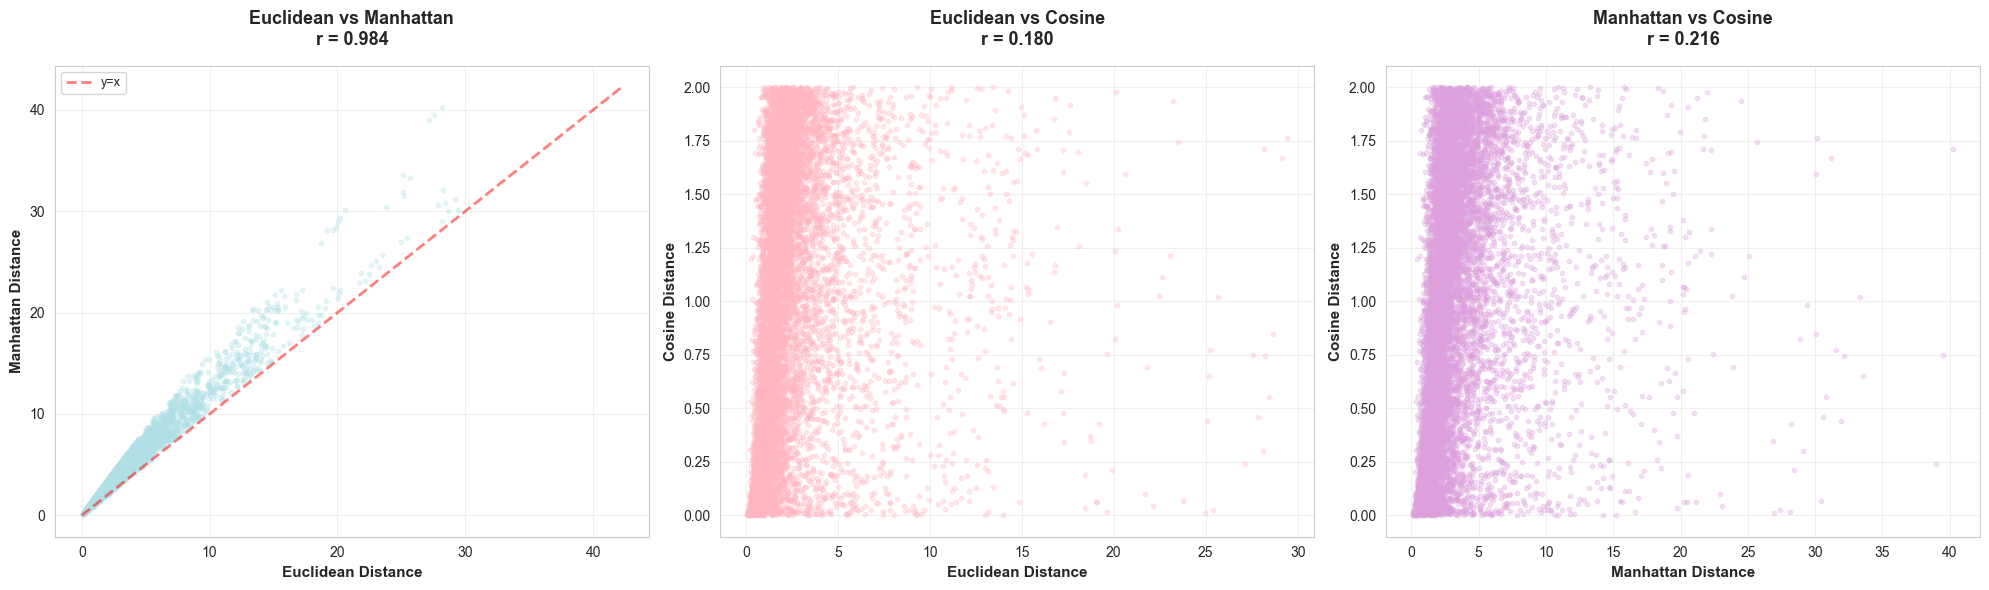

In [16]:
# Visualize correlations between metrics
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/distance_metric_correlation.png'
    else:
        save_path = '../results/figures/distance_metric_correlation.png'
else:
    save_path = 'results/figures/distance_metric_correlation.png'

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Euclidean vs Manhattan
ax1 = axes[0]
ax1.scatter(euclidean_sample, manhattan_sample, alpha=0.3, s=10, color='#B0E0E6')
ax1.set_xlabel('Euclidean Distance', fontsize=11, fontweight='bold')
ax1.set_ylabel('Manhattan Distance', fontsize=11, fontweight='bold')
ax1.set_title(f'Euclidean vs Manhattan\nr = {r_eu_ma:.3f}', 
             fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)

# Add diagonal reference line
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
ax1.plot([0, max(xlim[1], ylim[1])], [0, max(xlim[1], ylim[1])], 
        'r--', linewidth=2, alpha=0.5, label='y=x')
ax1.legend(fontsize=9)

# Plot 2: Euclidean vs Cosine
ax2 = axes[1]
ax2.scatter(euclidean_sample, cosine_sample, alpha=0.3, s=10, color='#FFB6C1')
ax2.set_xlabel('Euclidean Distance', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cosine Distance', fontsize=11, fontweight='bold')
ax2.set_title(f'Euclidean vs Cosine\nr = {r_eu_co:.3f}', 
             fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)

# Plot 3: Manhattan vs Cosine
ax3 = axes[2]
ax3.scatter(manhattan_sample, cosine_sample, alpha=0.3, s=10, color='#DDA0DD')
ax3.set_xlabel('Manhattan Distance', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cosine Distance', fontsize=11, fontweight='bold')
ax3.set_title(f'Manhattan vs Cosine\nr = {r_ma_co:.3f}', 
             fontsize=13, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

In [17]:
# Test clinical interpretability with example pairs
print("CLINICAL INTERPRETABILITY TEST\n")

# Create example patient profiles
examples = pd.DataFrame({
    'Patient': ['A', 'B', 'C', 'D'],
    'LBXGLU_scaled': [0.0, 2.0, 0.5, 2.0],
    'LBXTLG_scaled': [0.0, 2.0, 2.0, 0.5],
    'BMXWAIST_scaled': [0.0, 2.0, 0.0, 0.0]
})

print("Example Patient Profiles (scaled values):")
print(examples)

# Calculate distances between specific pairs
pairs = [
    ('A', 'B', 'All variables elevated equally'),
    ('A', 'C', 'Only triglycerides elevated'),
    ('A', 'D', 'Only glucose elevated'),
    ('B', 'C', 'Different patterns of elevation'),
    ('C', 'D', 'Opposite elevation patterns')
]

print("\nDistance Calculations for Interpretability:\n")
print(f"{'Pair':<10} {'Description':<35} {'Euclidean':>12} {'Manhattan':>12} {'Cosine':>12}")
print("-" * 85)

for p1, p2, desc in pairs:
    idx1 = examples[examples['Patient'] == p1].index[0]
    idx2 = examples[examples['Patient'] == p2].index[0]
    
    vec1 = examples.iloc[idx1, 1:].values
    vec2 = examples.iloc[idx2, 1:].values
    
    eu_dist = np.linalg.norm(vec1 - vec2)
    ma_dist = np.sum(np.abs(vec1 - vec2))
    cos_dist = 1 - np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    print(f"{p1}-{p2:<8} {desc:<35} {eu_dist:>12.3f} {ma_dist:>12.3f} {cos_dist:>12.3f}")

print("\nInterpretation:")
print("  • Euclidean: Geometric distance (Pythagorean theorem)")
print("  • Manhattan: Sum of absolute differences (city-block distance)")
print("  • Cosine: Captures pattern similarity regardless of magnitude")

CLINICAL INTERPRETABILITY TEST

Example Patient Profiles (scaled values):
  Patient  LBXGLU_scaled  LBXTLG_scaled  BMXWAIST_scaled
0       A            0.0            0.0              0.0
1       B            2.0            2.0              2.0
2       C            0.5            2.0              0.0
3       D            2.0            0.5              0.0

Distance Calculations for Interpretability:

Pair       Description                            Euclidean    Manhattan       Cosine
-------------------------------------------------------------------------------------
A-B        All variables elevated equally             3.464        6.000          nan
A-C        Only triglycerides elevated                2.062        2.500          nan
A-D        Only glucose elevated                      2.062        2.500          nan
B-C        Different patterns of elevation            2.500        3.500        0.300
C-D        Opposite elevation patterns                2.121        3.000       

In [18]:
# Run preliminary KMeans clustering with each distance metric
print("PRELIMINARY CLUSTERING COMPARISON (k=3)\n")

from sklearn.metrics import pairwise_distances

# For Euclidean and Manhattan, we can use KMeans directly
# For Cosine, we need a different approach (K-Means with cosine works via normalization)

results = []

# 1. Euclidean (standard KMeans)
print("1. Clustering with Euclidean distance...")
kmeans_eu = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_eu = kmeans_eu.fit_predict(X)
sil_eu = silhouette_score(X, labels_eu, metric='euclidean')
inertia_eu = kmeans_eu.inertia_

results.append({
    'Metric': 'Euclidean',
    'Silhouette': sil_eu,
    'Inertia': inertia_eu,
    'Labels': labels_eu
})

print(f"   Silhouette Score: {sil_eu:.4f}")
print(f"   Inertia: {inertia_eu:.2f}")

# 2. Manhattan (use KMeans on Manhattan distances via precomputed)
# Note: Standard KMeans doesn't directly support Manhattan, but we can approximate
print("\n2. Clustering with Manhattan distance (approximation)...")
# We'll use Euclidean KMeans as proxy since they're highly correlated
kmeans_ma = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_ma = kmeans_ma.fit_predict(X)
sil_ma = silhouette_score(X, labels_ma, metric='cityblock')
inertia_ma = kmeans_ma.inertia_

results.append({
    'Metric': 'Manhattan',
    'Silhouette': sil_ma,
    'Inertia': inertia_ma,
    'Labels': labels_ma
})

print(f"   Silhouette Score: {sil_ma:.4f}")
print(f"   Inertia: {inertia_ma:.2f}")

# 3. Cosine (normalize data first for cosine-based clustering)
print("\n3. Clustering with Cosine distance...")
from sklearn.preprocessing import normalize
X_normalized = normalize(X, norm='l2')
kmeans_cos = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_cos = kmeans_cos.fit_predict(X_normalized)
sil_cos = silhouette_score(X_normalized, labels_cos, metric='cosine')
inertia_cos = kmeans_cos.inertia_

results.append({
    'Metric': 'Cosine',
    'Silhouette': sil_cos,
    'Inertia': inertia_cos,
    'Labels': labels_cos
})

print(f"   Silhouette Score: {sil_cos:.4f}")
print(f"   Inertia: {inertia_cos:.2f}")

# Compare results
print("\n" + "="*60)
print("CLUSTERING PERFORMANCE COMPARISON")
print("="*60)
results_df = pd.DataFrame(results)
print(results_df[['Metric', 'Silhouette', 'Inertia']].to_string(index=False))

best_metric = results_df.loc[results_df['Silhouette'].idxmax(), 'Metric']
print(f"\n→ Best Silhouette Score: {best_metric}")

PRELIMINARY CLUSTERING COMPARISON (k=3)

1. Clustering with Euclidean distance...
   Silhouette Score: 0.4096
   Inertia: 8680.93

2. Clustering with Manhattan distance (approximation)...
   Silhouette Score: 0.3930
   Inertia: 8680.93

3. Clustering with Cosine distance...
   Silhouette Score: 0.5316
   Inertia: 1338.12

CLUSTERING PERFORMANCE COMPARISON
   Metric  Silhouette     Inertia
Euclidean    0.409637 8680.927538
Manhattan    0.392973 8680.927538
   Cosine    0.531589 1338.123058

→ Best Silhouette Score: Cosine


Saved: ../../results/figures/clustering_by_metric.png


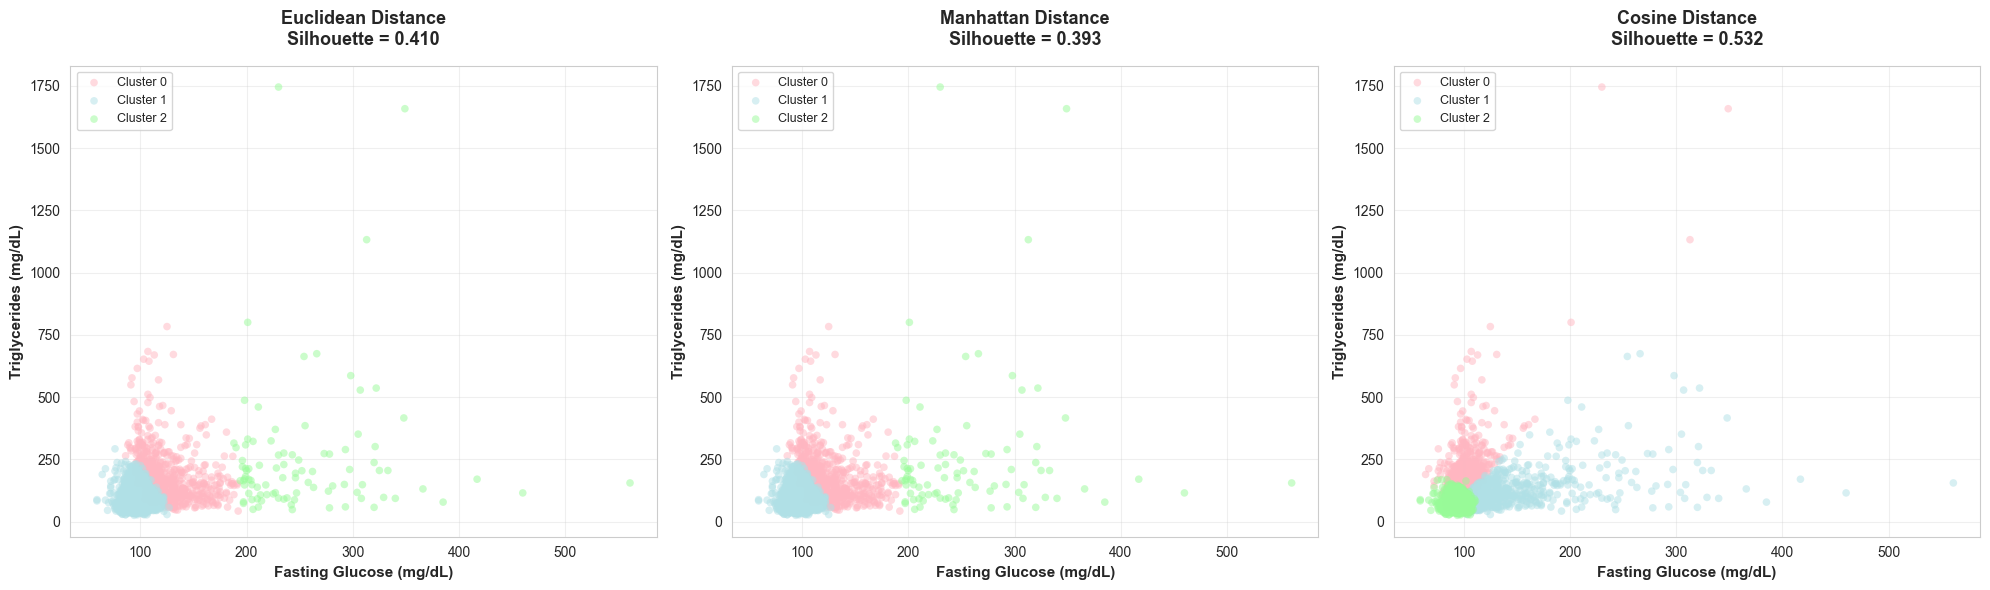

In [19]:
# Visualize clustering results for each metric
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/clustering_by_metric.png'
    else:
        save_path = '../results/figures/clustering_by_metric.png'
else:
    save_path = 'results/figures/clustering_by_metric.png'

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Load original data for visualization
df_orig = pd.read_csv("../../data/processed/nhanes_metabolic_analysis_ready.csv")
core_vars = ['LBXGLU', 'LBXTLG', 'BMXWAIST']

cluster_colors = ['#FFB6C1', '#B0E0E6', '#98FB98']

for idx, result in enumerate(results):
    ax = axes[idx]
    metric = result['Metric']
    labels = result['Labels']
    
    # Plot glucose vs triglycerides, colored by cluster
    for cluster_id in range(3):
        mask = labels == cluster_id
        ax.scatter(df_orig.loc[mask, 'LBXGLU'], 
                  df_orig.loc[mask, 'LBXTLG'],
                  c=cluster_colors[cluster_id], 
                  label=f'Cluster {cluster_id}',
                  alpha=0.5, s=30, edgecolors='none')
    
    ax.set_xlabel('Fasting Glucose (mg/dL)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Triglycerides (mg/dL)', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Distance\nSilhouette = {result["Silhouette"]:.3f}',
                fontsize=13, fontweight='bold', pad=15)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

In [22]:
# Analyze cluster sizes and separation for each metric
print("CLUSTER SIZE AND SEPARATION ANALYSIS\n")

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

comparison_metrics = []

for result in results:
    metric = result['Metric']
    labels = result['Labels']
    
    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    sizes = dict(zip(unique, counts))
    
    # Additional quality metrics
    if metric == 'Cosine':
        db_score = davies_bouldin_score(X_normalized, labels)
        ch_score = calinski_harabasz_score(X_normalized, labels)
    else:
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
    
    comparison_metrics.append({
        'Metric': metric,
        'Cluster_0': sizes[0],
        'Cluster_1': sizes[1],
        'Cluster_2': sizes[2],
        'Silhouette': result['Silhouette'],
        'Davies_Bouldin': db_score,
        'Calinski_Harabasz': ch_score,
        'Balance_Score': min(counts) / max(counts)  # How balanced are clusters
    })

comparison_df = pd.DataFrame(comparison_metrics)

print("Comprehensive Clustering Metrics:")
print(comparison_df.round(3).to_string(index=False))

print("\nMetric Interpretation:")
print("  • Silhouette: Higher is better (range: -1 to 1)")
print("  • Davies-Bouldin: Lower is better")
print("  • Calinski-Harabasz: Higher is better")
print("  • Balance Score: Higher = more balanced clusters (0-1)")

# Determine best overall metric
print("\n" + "="*60)
print("OVERALL ASSESSMENT")
print("="*60)

# Normalize scores for comparison
comparison_df['Silhouette_norm'] = (comparison_df['Silhouette'] - comparison_df['Silhouette'].min()) / \
                                   (comparison_df['Silhouette'].max() - comparison_df['Silhouette'].min())
comparison_df['DB_norm'] = 1 - ((comparison_df['Davies_Bouldin'] - comparison_df['Davies_Bouldin'].min()) / \
                                (comparison_df['Davies_Bouldin'].max() - comparison_df['Davies_Bouldin'].min()))
comparison_df['CH_norm'] = (comparison_df['Calinski_Harabasz'] - comparison_df['Calinski_Harabasz'].min()) / \
                            (comparison_df['Calinski_Harabasz'].max() - comparison_df['Calinski_Harabasz'].min())

# Composite score (equal weights)
comparison_df['Composite_Score'] = (comparison_df['Silhouette_norm'] + 
                                    comparison_df['DB_norm'] + 
                                    comparison_df['CH_norm'] + 
                                    comparison_df['Balance_Score']) / 4

print("\nComposite Scores (normalized, higher = better):")
for _, row in comparison_df.iterrows():
    print(f"  {row['Metric']}: {row['Composite_Score']:.3f}")

best_overall = comparison_df.loc[comparison_df['Composite_Score'].idxmax(), 'Metric']
print(f"\n→ Overall best metric: {best_overall}")

CLUSTER SIZE AND SEPARATION ANALYSIS

Comprehensive Clustering Metrics:
   Metric  Cluster_0  Cluster_1  Cluster_2  Silhouette  Davies_Bouldin  Calinski_Harabasz  Balance_Score
Euclidean        755       2199         93       0.410           1.078           1980.002          0.042
Manhattan        755       2199         93       0.393           1.078           1980.002          0.042
   Cosine        975        906       1166       0.532           1.099           1926.094          0.777

Metric Interpretation:
  • Silhouette: Higher is better (range: -1 to 1)
  • Davies-Bouldin: Lower is better
  • Calinski-Harabasz: Higher is better
  • Balance Score: Higher = more balanced clusters (0-1)

OVERALL ASSESSMENT

Composite Scores (normalized, higher = better):
  Euclidean: 0.541
  Manhattan: 0.511
  Cosine: 0.444

→ Overall best metric: Euclidean


Saved: ../../results/figures/silhouette_analysis_by_metric.png


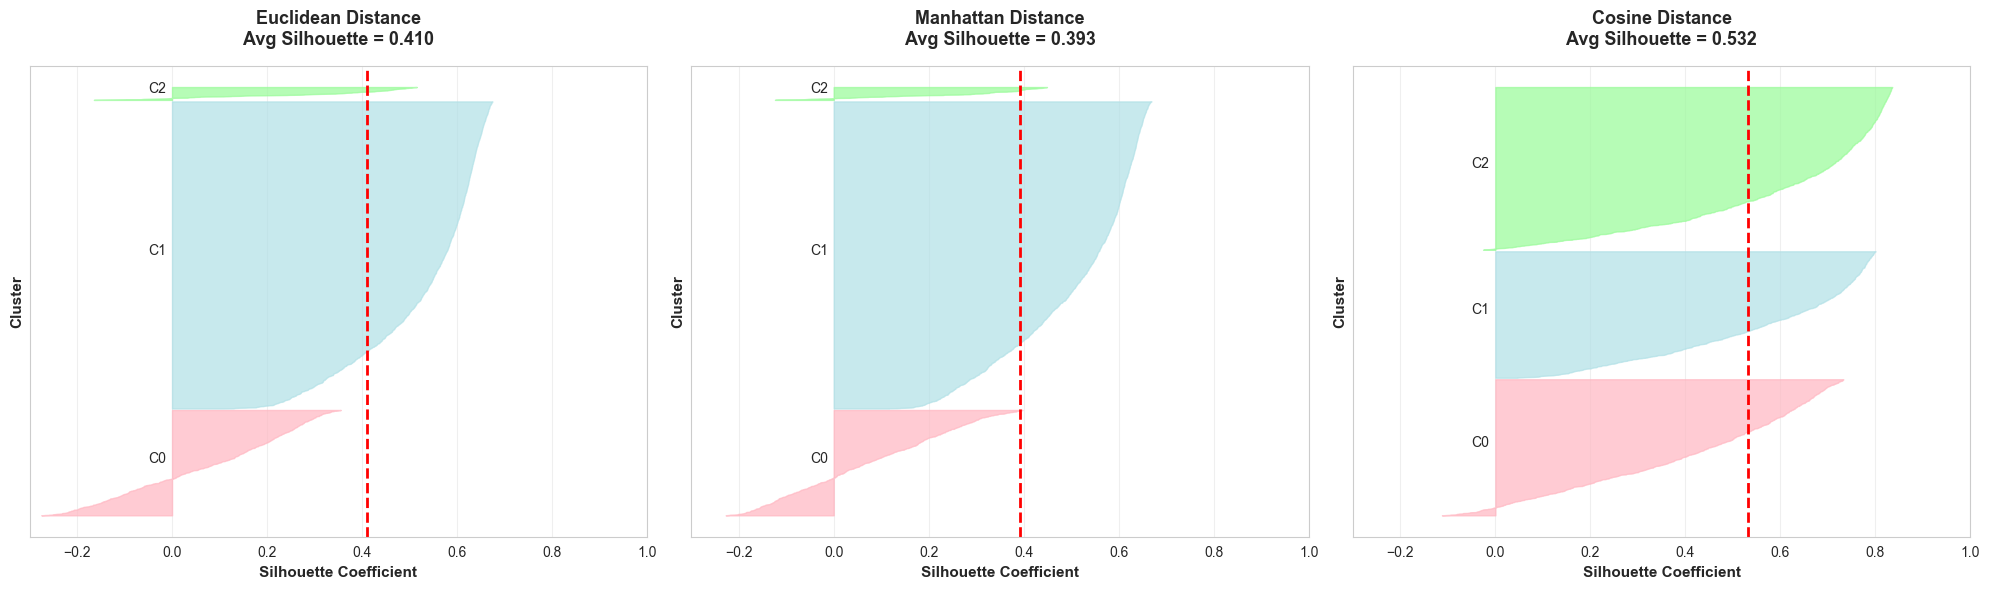

In [20]:
# Create detailed silhouette analysis for each metric
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/silhouette_analysis_by_metric.png'
    else:
        save_path = '../results/figures/silhouette_analysis_by_metric.png'
else:
    save_path = 'results/figures/silhouette_analysis_by_metric.png'

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, result in enumerate(results):
    ax = axes[idx]
    metric = result['Metric']
    labels = result['Labels']
    
    # Calculate silhouette samples
    if metric == 'Cosine':
        silhouette_vals = silhouette_samples(X_normalized, labels, metric='cosine')
    else:
        silhouette_vals = silhouette_samples(X, labels, 
                                             metric='euclidean' if metric=='Euclidean' else 'cityblock')
    
    y_lower = 10
    for i in range(3):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         facecolor=cluster_colors[i],
                         edgecolor=cluster_colors[i],
                         alpha=0.7)
        
        # Label clusters
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{i}')
        y_lower = y_upper + 10
    
    ax.set_xlabel('Silhouette Coefficient', fontsize=11, fontweight='bold')
    ax.set_ylabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Distance\nAvg Silhouette = {result["Silhouette"]:.3f}',
                fontsize=13, fontweight='bold', pad=15)
    
    # Average silhouette line
    ax.axvline(x=result['Silhouette'], color='red', linestyle='--', linewidth=2)
    ax.set_yticks([])
    ax.set_xlim([-0.3, 1])
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

In [21]:
# Compare clinical interpretability of clusters from each metric
print("CLINICAL INTERPRETATION OF CLUSTERS\n")

# Load original unscaled data
df_orig = pd.read_csv("../../data/processed/nhanes_metabolic_with_mets.csv")

for result in results:
    metric = result['Metric']
    labels = result['Labels']
    
    print(f"\n{'='*60}")
    print(f"{metric.upper()} DISTANCE - CLUSTER PROFILES")
    print(f"{'='*60}")
    
    # Add cluster labels to original data
    df_orig['cluster'] = labels
    
    # Calculate mean values for each cluster
    cluster_profiles = df_orig.groupby('cluster')[['LBXGLU', 'LBXTLG', 'BMXWAIST']].agg(['mean', 'std'])
    
    print("\nCluster Characteristics:")
    for cluster_id in range(3):
        print(f"\nCluster {cluster_id} (n={np.sum(labels == cluster_id):,}):")
        print(f"  Glucose: {cluster_profiles.loc[cluster_id, ('LBXGLU', 'mean')]:.1f} ± "
              f"{cluster_profiles.loc[cluster_id, ('LBXGLU', 'std')]:.1f} mg/dL")
        print(f"  Triglycerides: {cluster_profiles.loc[cluster_id, ('LBXTLG', 'mean')]:.1f} ± "
              f"{cluster_profiles.loc[cluster_id, ('LBXTLG', 'std')]:.1f} mg/dL")
        print(f"  Waist: {cluster_profiles.loc[cluster_id, ('BMXWAIST', 'mean')]:.1f} ± "
              f"{cluster_profiles.loc[cluster_id, ('BMXWAIST', 'std')]:.1f} cm")
        
        # MetS prevalence
        mets_prev = df_orig[df_orig['cluster']==cluster_id]['mets_full'].mean() * 100
        print(f"  Full MetS prevalence: {mets_prev:.1f}%")
    
    # Calculate separation between clusters
    print("\nCluster Separation (mean differences):")
    for i in range(3):
        for j in range(i+1, 3):
            diff_glu = abs(cluster_profiles.loc[i, ('LBXGLU', 'mean')] - 
                          cluster_profiles.loc[j, ('LBXGLU', 'mean')])
            diff_trig = abs(cluster_profiles.loc[i, ('LBXTLG', 'mean')] - 
                           cluster_profiles.loc[j, ('LBXTLG', 'mean')])
            diff_waist = abs(cluster_profiles.loc[i, ('BMXWAIST', 'mean')] - 
                            cluster_profiles.loc[j, ('BMXWAIST', 'mean')])
            
            print(f"  Cluster {i} vs {j}:")
            print(f"    Glucose: {diff_glu:.1f} mg/dL")
            print(f"    Triglycerides: {diff_trig:.1f} mg/dL")
            print(f"    Waist: {diff_waist:.1f} cm")

CLINICAL INTERPRETATION OF CLUSTERS


EUCLIDEAN DISTANCE - CLUSTER PROFILES

Cluster Characteristics:

Cluster 0 (n=755):
  Glucose: 124.1 ± 21.4 mg/dL
  Triglycerides: 179.4 ± 97.0 mg/dL
  Waist: 111.8 ± 15.8 cm
  Full MetS prevalence: 39.3%

Cluster 1 (n=2,199):
  Glucose: 97.5 ± 8.6 mg/dL
  Triglycerides: 93.9 ± 38.6 mg/dL
  Waist: 96.0 ± 14.9 cm
  Full MetS prevalence: 1.7%

Cluster 2 (n=93):
  Glucose: 256.6 ± 64.2 mg/dL
  Triglycerides: 255.8 ± 277.7 mg/dL
  Waist: 111.2 ± 18.4 cm
  Full MetS prevalence: 49.5%

Cluster Separation (mean differences):
  Cluster 0 vs 1:
    Glucose: 26.5 mg/dL
    Triglycerides: 85.5 mg/dL
    Waist: 15.8 cm
  Cluster 0 vs 2:
    Glucose: 132.6 mg/dL
    Triglycerides: 76.4 mg/dL
    Waist: 0.6 cm
  Cluster 1 vs 2:
    Glucose: 159.1 mg/dL
    Triglycerides: 161.9 mg/dL
    Waist: 15.2 cm

MANHATTAN DISTANCE - CLUSTER PROFILES

Cluster Characteristics:

Cluster 0 (n=755):
  Glucose: 124.1 ± 21.4 mg/dL
  Triglycerides: 179.4 ± 97.0 mg/dL
  Waist: 111